# Adventures in P-Typing
### Using Natural Language Processing and Data Science to Explore the Myers-Briggs Personality Test

## Introduction

The Myers-Brigs Type Indicator (MBTI) is a self-assessment questionnaire which helps people gain insight into how they work and learn. The test was developed by the mother-daughter partnership of Katharine Briggs and Isabel Briggs-Myers and is based on the typological theory of Carl Jung. The length of the test can range from 93 to 222 items that serve to identify a participant's personality type based on four key preferences on how they interract and deal with the world around them. 

These preferances are choices between the following:
1. People and things- Extraversion (E) vs Ideas and information- Introversion (I)
2. Facts and reality- Sensing (S) vs Possibilities and potential- Intuition (N)
3. Logic and truth- Thinking (T) vs Values and relationships- Feeling (F)
4. A lifestyle that is well-structured- Judgment (J) vs One that goes with the flow- Perception (P) 

The combination of these 4 preferences will determine which personality type a person would fall into. For example, an Extroverted, Sensing, Thinking, Judgment based person would be categorized as an ESTJ personality type. This particular type is labeled the "Executive" and is described as being dedicated, strong-willed, direct, loyal, patient, reliable, and well-ordered.   

There are 16 types in total as well as another category that indicates the level of confidence one has in their abilities which ranges from Assertive (A) to Turbulent (T). But for the purposes of this project, that last category will be left out.

## The Project

My intent is to use text samples from the different personality types to build a predictive model. 

As stated earlier, the MBTI can range from 93 to 222 items. Would it be possible to avoid having to take the test and get one's personality type based off of their writing samples alone?

## The Dataset

I found this [dataset](https://www.kaggle.com/datasnaek/mbti-type) on the Kaggle website. It is a collection of the last 50 forum posts from 8675 members of the [Personality Cafe](http://personalitycafe.com) community. Personality Cafe is an online platform that describes itself as "a community dedicated to helping you develop your personality through interactions with people who have the same personality as you".

## The Analysis

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_download = pd.read_csv('mbti_1.csv')

In [104]:
data = data_download.copy()

We start with 2 columns and 8675 rows of data. One column is the represents the personality type and the other is represents the posts.

In [105]:
print(data.shape)
pd.options.display.max_colwidth = 100
data.head()

(8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of th..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to b...


### Initial Exploration

The graph below indicates that there is a vast imbalance in the representation of the different personality types.  This does not bode well for building a model that is capible of accurately predicting the different categories.

The biggest group, INFP, has over 1,750 samples whereas the smallest group, ESTJ, has less than 50. I find it fascinating that these two groups are the exact opposite of one another. INFP stands for __I__ntrovert, I__n__tuitive, __F__eeling, and __P__rospecting while ESTJ stands for __E__xtrovert, __S__ensing, __T__hinking, and __J__udging. Perhaps it is the polarization of their traights that led them to being represented as such. 

I also find it interesting that the top four groups start with IN (Introvert/Intuitive) while the bottom four start with ES (Extrovert/Sensing). It would make sense that introverted people would spend more time communicating with other via these message boards while entroverts would prefer to interract with people in person. Also, it would be more likely that Intuitive people would enjoy the theoretical and complex topic of personality while sensing people maybe turned off by its lack of concrete definition.

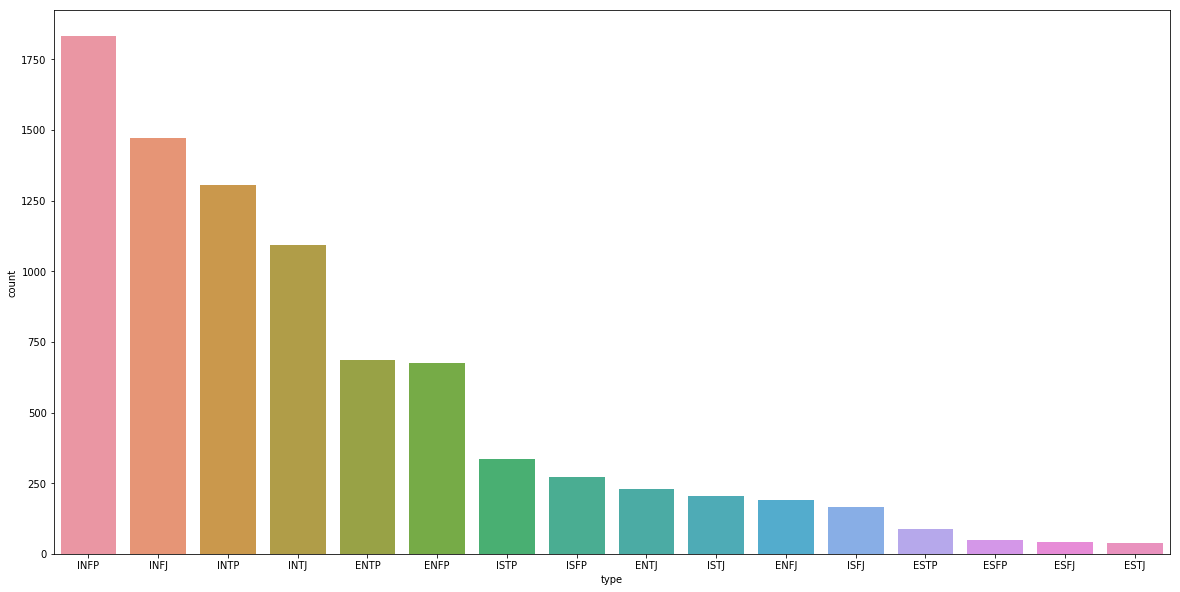

In [84]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.countplot(x="type", data=data, order = data.type.value_counts().index)
plt.show()

Here is a bigger look at the text.

I see that I'll have to get rid of the ||| separators and a few embedded links. I will replace the links with 'https' since the presence of links may be a useful predictive feature.

I see too that the writer mentions their personality classification. In this case, 'ENTP'. I will remove that since I would like to create a model that can predict the personality classification of people who are not aware of their classifications. Although even with the ommision of the types, I'm certain that this self awareness and the fact that these posts come from a forum where people explore and discuss the meaning of their personality types would still play a factor in the success of the model. 

In [6]:
pd.options.display.max_colwidth = 1000
print(data.loc[1,['posts']])

posts    'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/60

### Processing the Data

As with all text samples, there is some data processing to be done.

For clean up, I will do the following:

1.  replace urls with 'https'
2.  punctuation removal (and other random symbols)
3.  remove digits 
4.  lowercase and stop word removal
5.  remove excess white space
6.  remove the types

In [85]:
import re
from string import punctuation
from nltk.corpus import stopwords

In [106]:
def remove_url(x):
    x = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', 'https', x)
    return x
data.posts = data.posts.apply(remove_url)

In [107]:
punctuation_symbols = []

for each in list(punctuation):
    punctuation_symbols.append((each, ' '))
    
def remove_puncuation(x):
    for each in punctuation_symbols:
        x = x.replace(*each)
    return x

data.posts = data.posts.apply(remove_puncuation)

In [108]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

data.posts = data.posts.apply(remove_digits)

In [109]:
stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

data.posts = data.posts.apply(remove_stop_words)

In [110]:
def remove_extra_white_space(x):
    x = ' '.join(x.split())
    return x

data.posts = data.posts.apply(remove_extra_white_space)

In [111]:
def remove_types(x):
    x = re.sub(r'(i|e)(n|s)(t|f)(j|p)\w*|\b(ne|sx|ni|ti|fe|nt)\b', '', x)
    return x

data.posts = data.posts.apply(remove_types)

Looking at the cleaned up text, I see that there are still issues with some Myers-Briggs abbreviations such as 'e', 'j', 'p', 'ne', 'ti', and 'si'. I will leave these in for now since I don't know enough about the MBIT to do a thorough job of removing them all. 

In [113]:
pd.options.display.max_colwidth = 1000
print(data.loc[1,['posts']])

posts    finding lack posts alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough giving new meaning game theory hello  grin takes converse flirting acknowledge presence return words smooth wordplay cheeky grins lack balance hand eye coordination real iq test score internet iq tests funny score higher like former responses thread mention believe iq test banish know  vanish site year half return find people still commenting posts liking ideas thoughts know  https think things sometimes go old sherlock holmes quote perhaps man special knowledge special powers like rather encourages seek complex cheshirewolf tumblr com post really never thought e j p real functions judge use use   dominates  emotions rarely si also use  due strength know though ingenious saying really want try see happens playing first person shooter back drive around want see look rock paper one best makes lol guys lucky really high tumblr system hear new fir

## Predictive Model Using TF-IDF Words as Features

I will now use the cleaned up text and input into the TF-IDF Vectorizer. From there, I will create my predictive models.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0.02, stop_words = 'english', norm='l2')

In [114]:
# fit & transform
tfidf_matrix = tf.fit_transform(data.posts)

print('Number of documents:', tfidf_matrix.shape[0], ', number of features:', tfidf_matrix.shape[1])

Number of documents: 8675 , number of features: 3462


In [115]:
tfidf_feature_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
tfidf_feature_matrix.head()

,abilities,ability,able,absolute,absolutely,absolutely love,abstract,absurd,abuse,abusive,...,yes yes,yesterday,yo,young,younger,youth,youtube,yup,zero,zone
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.083408,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.000000,0.030959,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.108738,0.037717,0.000000,0.090886,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.06969,0.0,0.0
3,0.0,0.000000,0.064002,0.060133,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [19]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

In [116]:
X = tfidf_feature_matrix
Y = data['type']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 


Random Forest Classifier:
Training set score: 0.993544420535
Test set score: 0.22683264177


In [21]:
from sklearn.linear_model import LogisticRegression

In [117]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))


Logistic Regression:
Training set score: 0.584229941592
Test set score: 0.368372521899


As somewhat expected, neither the Random Forest Classifier nor the Logistic Regression models did very well. This is primarily due to the fact that several of the groups were ill represented. 

The following confusion matrix supports that hypothesis as the 'IN' personality types are the ones that were identified most often. They also had higher recall and precision scores.

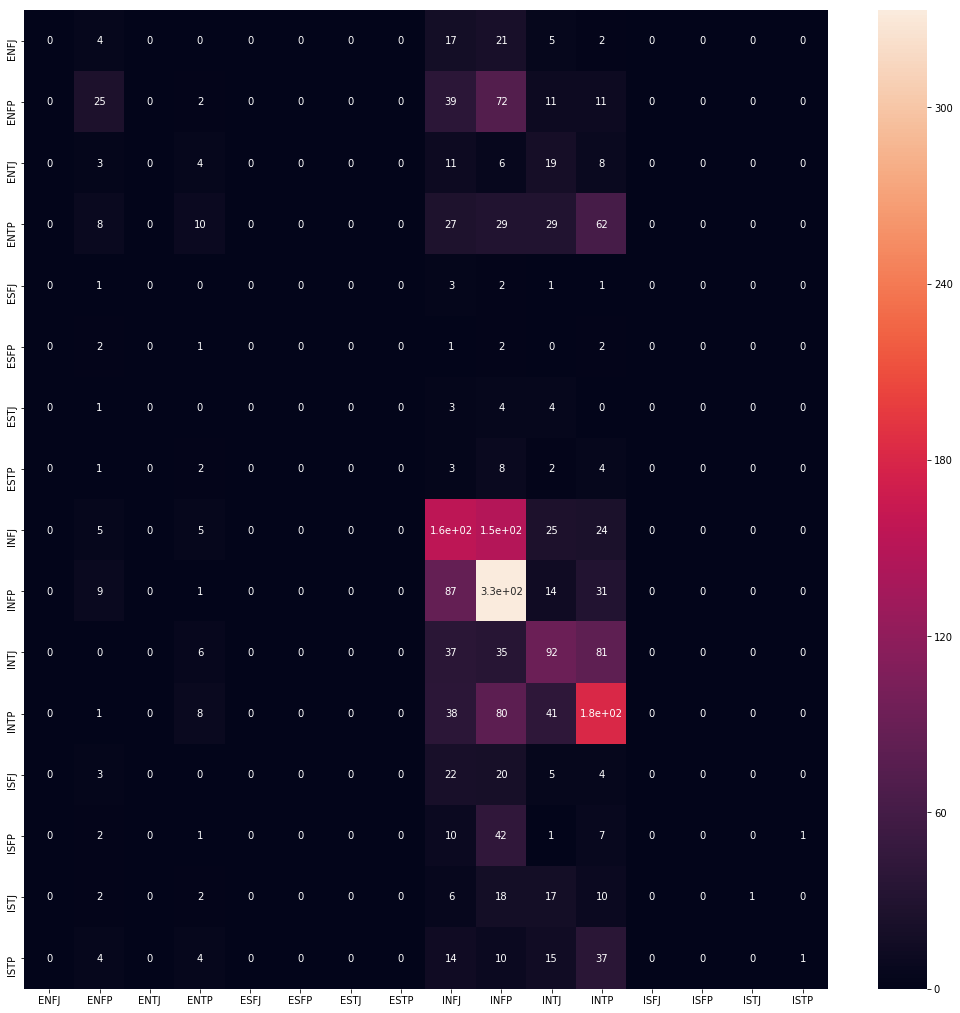

             precision    recall  f1-score   support

       ENFJ       0.00      0.00      0.00        49
       ENFP       0.35      0.16      0.22       160
       ENTJ       0.00      0.00      0.00        51
       ENTP       0.22      0.06      0.09       165
       ESFJ       0.00      0.00      0.00         8
       ESFP       0.00      0.00      0.00         8
       ESTJ       0.00      0.00      0.00        12
       ESTP       0.00      0.00      0.00        20
       INFJ       0.33      0.43      0.37       361
       INFP       0.40      0.70      0.51       475
       INTJ       0.33      0.37      0.35       251
       INTP       0.39      0.52      0.45       350
       ISFJ       0.00      0.00      0.00        54
       ISFP       0.00      0.00      0.00        64
       ISTJ       1.00      0.02      0.04        56
       ISTP       0.50      0.01      0.02        85

avg / total       0.33      0.37      0.31      2169



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [118]:
from sklearn.metrics import confusion_matrix
personality_types = sorted(data.type.unique())

Y_pred = lr.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (18,18))
sns.heatmap(df_cm, annot=True)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, target_names=personality_types))

---
## Predictive Models Based on Individual Traits 

Upon reflection and the suggestion of my mentor, I decided to create new columns that would identify each sample by their individual traits. Meaning, I would have a separate column for Introvert/Extrovert, Intuitive/Sensing, Thinking/Feeling, and Judging/Prospecting.

In [119]:
tfidf_feature_matrix2 = tfidf_feature_matrix.copy()

In [120]:
tfidf_feature_matrix2['type_IE'] = [x[0] for x in data.type]
tfidf_feature_matrix2['type_NS'] = [x[1] for x in data.type]
tfidf_feature_matrix2['type_TF'] = [x[2] for x in data.type]
tfidf_feature_matrix2['type_JP'] = [x[3] for x in data.type]

In [121]:
tfidf_feature_matrix2.head()

,abilities,ability,able,absolute,absolutely,absolutely love,abstract,absurd,abuse,abusive,...,younger,youth,youtube,yup,zero,zone,type_IE,type_NS,type_TF,type_JP
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,I,N,F,J
1,0.0,0.000000,0.030959,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,E,N,T,P
2,0.0,0.108738,0.037717,0.000000,0.090886,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.06969,0.0,0.0,I,N,T,P
3,0.0,0.000000,0.064002,0.060133,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,I,N,T,J
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,E,N,T,J


Below is a breakdown of how balanced the number of samples are in each pair. The most even numbered being Thinking/Feeling while the least being Intuitive/Sensing. 

I    6676
E    1999
Name: type_IE, dtype: int64 

N    7478
S    1197
Name: type_NS, dtype: int64 

F    4694
T    3981
Name: type_TF, dtype: int64 

P    5241
J    3434
Name: type_JP, dtype: int64 



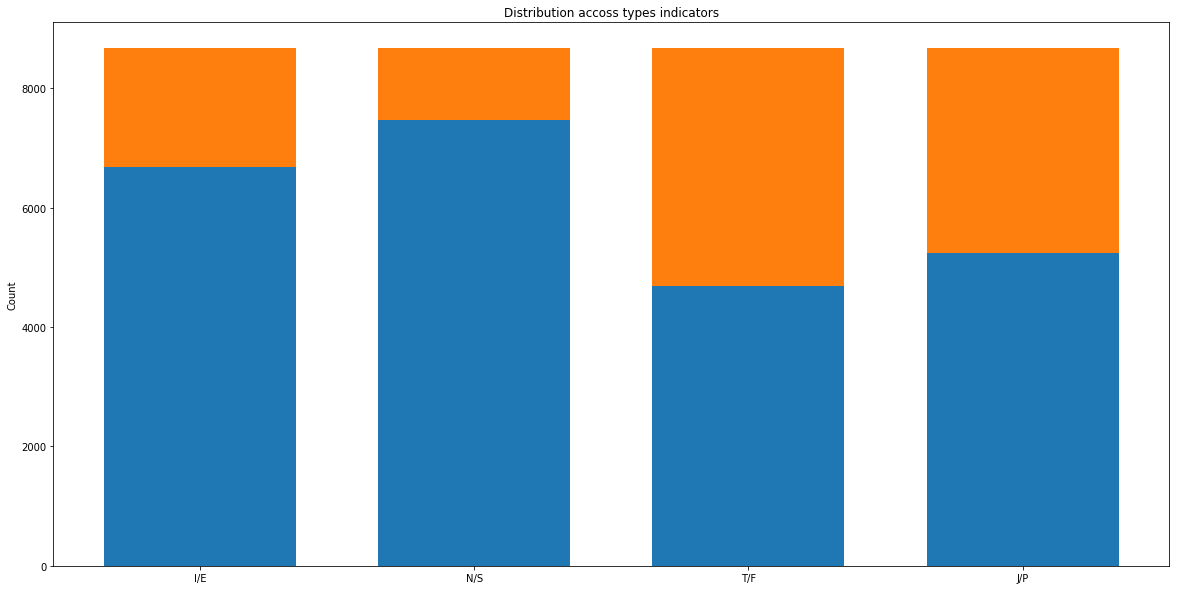

In [122]:
print(tfidf_feature_matrix2.type_IE.value_counts(), '\n')
print(tfidf_feature_matrix2.type_NS.value_counts(), '\n')
print(tfidf_feature_matrix2.type_TF.value_counts(), '\n')
print(tfidf_feature_matrix2.type_JP.value_counts(), '\n')

N = 4
but = (tfidf_feature_matrix2.type_IE.value_counts()[0], tfidf_feature_matrix2.type_NS.value_counts()[0], 
       tfidf_feature_matrix2.type_TF.value_counts()[0], tfidf_feature_matrix2.type_JP.value_counts()[0])
top = (tfidf_feature_matrix2.type_IE.value_counts()[1], tfidf_feature_matrix2.type_NS.value_counts()[1], 
       tfidf_feature_matrix2.type_TF.value_counts()[1], tfidf_feature_matrix2.type_JP.value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

I will do a random sampling of Introvert/Extrovert and Intuitive/Sensing to get a more balanced set of numbers. I'm sure, however, that these models won't do as well due to the smaller sample sizes. 

### Introvert/Extrovert Model:

In [123]:
data_I = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_IE'] == 'I'].sample(n=1999)
print(data_I.shape)
data_E = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_IE'] == 'E']
print(data_E.shape)
data_IE = pd.concat([data_I, data_E])
print(data_IE.shape)

(1999, 3466)
(1999, 3466)
(3998, 3466)


In [39]:
drop_list = ['type_IE','type_NS',"type_TF",'type_JP']
# test = data_IE.drop(drop_list, axis=1).shape


Random Forest Classifier:
Training set score: 0.988659106071

Cross Validation Scores:
 [ 0.53875     0.54        0.54875     0.5525      0.52882206]

Logistic Regression:
Training set score: 0.846897931955

Cross Validation Scores:
 [ 0.68625     0.67        0.71125     0.67125     0.66290727]


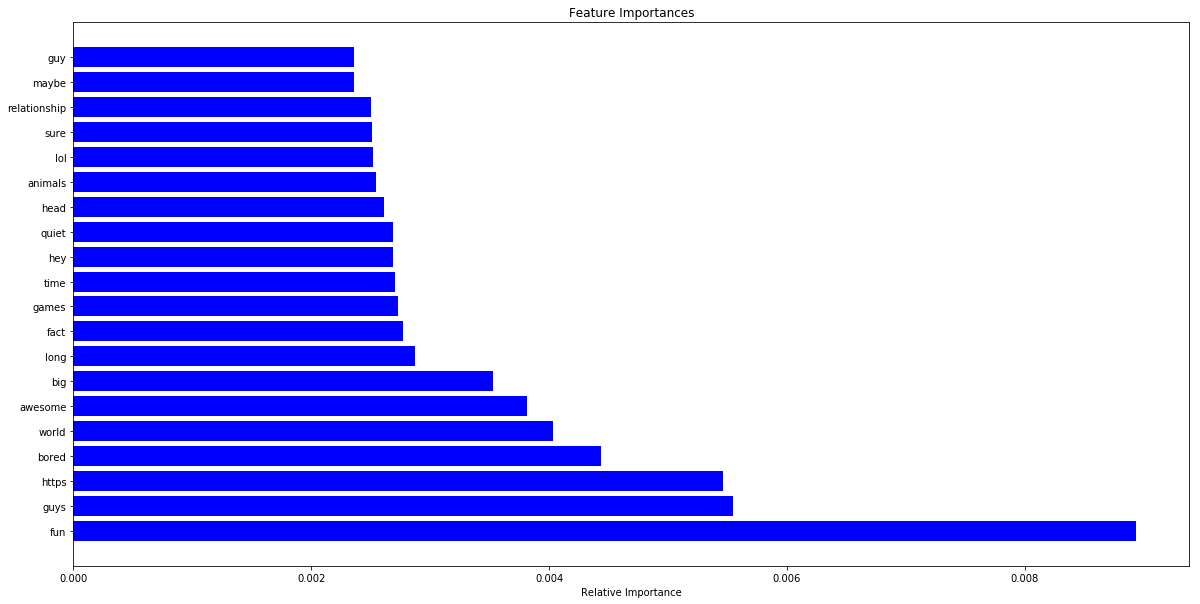

In [124]:
from sklearn.model_selection import cross_val_score

Y = data_IE['type_IE']
X = data_IE.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_IE = ensemble.RandomForestClassifier()

rfc_IE.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_IE.score(X_train, Y_train))

print('\nCross Validation Scores:\n' , cross_val_score(rfc_IE, X, Y, cv=5))  

lr_IE = LogisticRegression()
lr_IE.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_IE.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr_IE, X, Y, cv=5))  

features = X.columns
importances = rfc_IE.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

The Introvert/Extrovert models scored in the mid 50s for Random Forest Classifier and mid 60s for Logistic Regression.

I ran a feature importance that ended up being rather unstable, which is understandably given the lower scores. There were a few words that did show up consistantly that I found to be insightful though. Words like 'fun', 'haha', and 'lol' could indicate a more outgoing personality while words like 'think' and 'listen' could be associated with introversion. 

The presence of 'https' shows a preference for sharing links to other websites. As in Introvert, I can identify to posting links since it saves me the effort of actually communicating with others.

---
### Intuitive/Sensing Model:

In [125]:
data_N = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_NS'] == 'N'].sample(n=1197)
print(data_N.shape)
data_S = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_NS'] == 'S']
print(data_S.shape)
data_NS = pd.concat([data_N, data_S])
print(data_NS.shape)

(1197, 3466)
(1197, 3466)
(2394, 3466)



Random Forest Classifier:
Training set score: 0.987186629526

Cross Validation Scores:
 [ 0.54583333  0.54791667  0.58368201  0.55648536  0.53556485]

Logistic Regression:
Training set score: 0.892479108635

Cross Validation Scores:
 [ 0.68125     0.67083333  0.67154812  0.70292887  0.68410042]


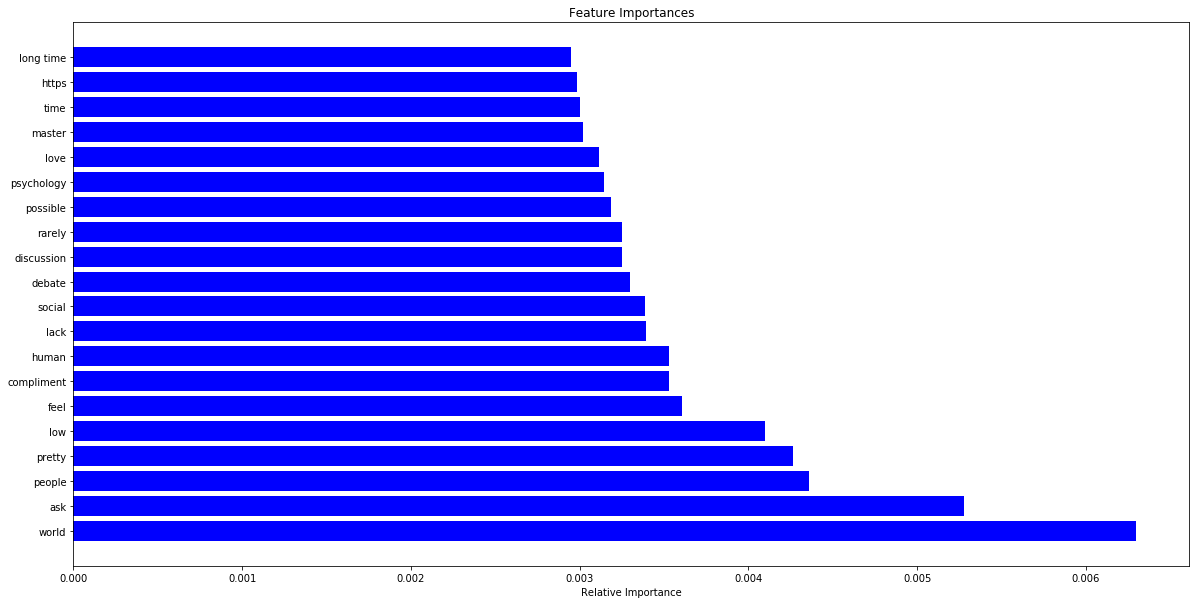

In [126]:
Y = data_NS['type_NS']
X = data_NS.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_NS = ensemble.RandomForestClassifier()

rfc_NS.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_NS.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc_NS, X, Y, cv=5))  

lr_NS = LogisticRegression()
lr_NS.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_NS.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr_NS, X, Y, cv=5))

features = X.columns
importances = rfc_NS.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

With the lower scores, this model as well had unstable features. It did, however, have a handful of words that consistantly showed up.

Sensing types base their understanding of the world on concrete and measurable facts. Words like 'know', 'knowledge', and 'reality' could definitely indicate a sensing type person.

On the opposite end, intuitive types are more likely to go by their internal feelings and concepts about the world. The word features that could distinguish an Intuitive personality are 'feel', 'believe', and 'thoughts'.

---
### Judging/Prospecting Model:


Random Forest Classifier:
Training set score: 0.989548109437

Cross Validation Scores:
 [ 0.5483871   0.54639769  0.56599424  0.54985591  0.544406  ]

Logistic Regression:
Training set score: 0.778204734092

Cross Validation Scores:
 [ 0.65668203  0.64668588  0.66916427  0.64322767  0.65109573]


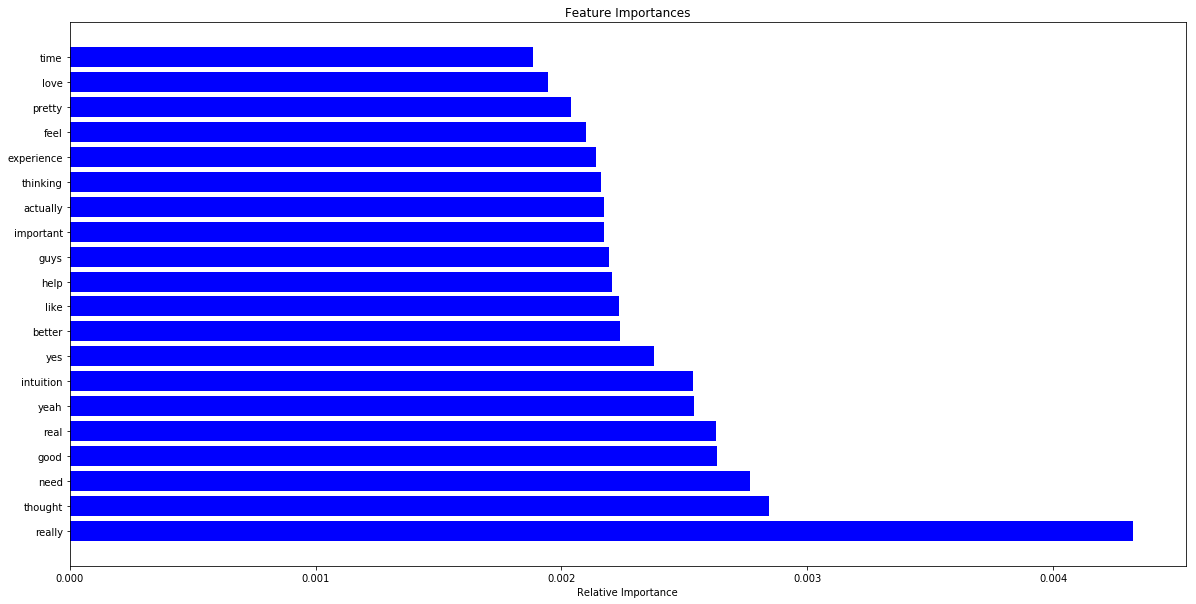

In [127]:
Y = tfidf_feature_matrix2['type_JP']
X = tfidf_feature_matrix2.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_JP = ensemble.RandomForestClassifier()

rfc_JP.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_JP.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc_JP, X, Y, cv=5))  

lr_JP = LogisticRegression()
lr_JP.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_JP.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr_JP, X, Y, cv=5)) 

features = X.columns
importances = rfc_JP.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Judging vs Prospecting Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Despite having a bigger sample size, the Judging/Prospecting model didn't do much better. 

I partial attribute this to the criteria that separates the Judging from Prospecting. Judging types are more structured and like to plan whereas Propspecting types or more likely to be spontaneous and go with the flow. This may be difficult for the model to pick up on. 

The one word that I noticed that would be a good indicator is 'plan'. The others didn't stand out to me much.

### Thinking/Feeling Model:


Random Forest Classifier:
Training set score: 0.987703658162

Cross Validation Scores:
 [ 0.63767281  0.64322767  0.63804035  0.63746398  0.61995386]

Logistic Regression:
Training set score: 0.861358745773

Cross Validation Scores:
 [ 0.81624424  0.79365994  0.78270893  0.79020173  0.77854671]


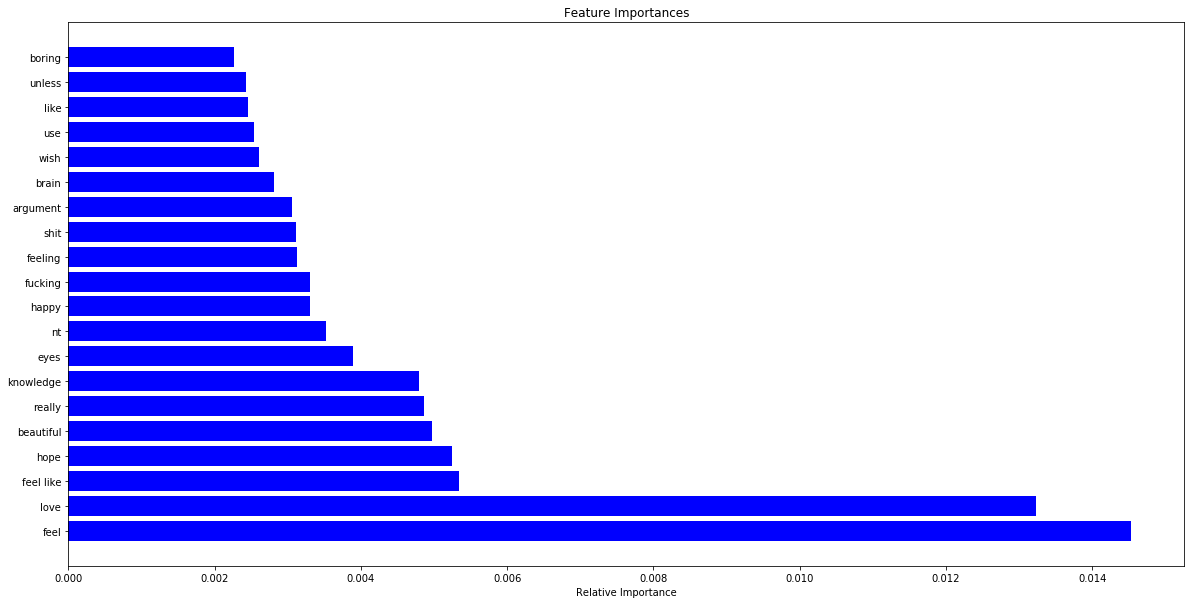

In [128]:
Y = tfidf_feature_matrix2['type_TF']
X = tfidf_feature_matrix2.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_TF = ensemble.RandomForestClassifier()

rfc_TF.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_TF.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(rfc_TF, X, Y, cv=5))  

lr_TF = LogisticRegression()
lr_TF.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_TF.score(X_train, Y_train))
print('\nCross Validation Scores:\n' , cross_val_score(lr_TF, X, Y, cv=5))  

features = X.columns
importances = rfc_TF.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

This model did by far the strongest which makes sense given that it had the biggest sample size. 

The feature importance was also very stable. Thinking/Feeling is more about how somebody will make decisions based on facts vs emotions. Thus, words like 'feel', feeling' and 'feel like' would of course point to a Feeling person whereas 'think' and 'knowledge' would indicate a Thinking person.

In [129]:
import tweepy

ckey = "zLceR2GtRk7LiUMXRzLAYQ1ML"
csecret = "gUQWOfGKI7voYlfLD5rpl5KiQrXQTpzIQXLmPjsaYQO3cGhefo"
atoken = "819671108-WsXdRIP2tk9oBbh9ISPXAnKfVv567xPX1OsBDfSt"
asecret = "FSGAGxj2atE2HKqGlLYUS3KC9NGtzc8akeqlNBDrfgc1C"

auth = tweepy.OAuthHandler(ckey, csecret)

auth.set_access_token(atoken, asecret)

api = tweepy.API(auth)

stuff = api.user_timeline(screen_name = 'inkandstars', count = 100, include_rts = False)

twitter_text = ''
for status in stuff:
    twitter_text += status.text
    twitter_text += ' '
    
print(twitter_text)

@LASwann07 💜 @Ivysani742 @jvoyageur 🌹 @ellen_andersen1 🦋💕 @mortaledamnati Thank you! 💜✨🌜 @ENobutterfly @btp2222 💜 a pleasure to share 🦋 @susanmreif 💜 @Nightflower_N i know i am responding quite late to this, but i've recently had same and my migraines have changed.… https://t.co/P0haOW0w4L @Nightflower_N so very sweet 💕 @natureslover_s 💕lol... I love this. it is me. @Crystal_Fishy love! 💜☺️ @ellen_andersen1 thank you, you are so kind... i am trying 💕✨🌙 @ellen_andersen1 💜i love all of her photos @Crystal_Fishy 💜yes, it always makes me tear up but softly smile too... it's just very delicate and sweet gone to dream 🦋 '2303 03 Am’ by Forelight on #SoundCloud? #np https://t.co/Hf9fwKhTM7 d  r  e  a  m

© carl yoshihara https://t.co/ir5Fs917vX Slowdive | Souvlaki (Full Album) | 1994 (US Release with bonus tracks) https://t.co/N69uQspJlN via @YouTube thank you 💜

anna o https://t.co/L1APbmvGxT Suzanne .:. Leonard Cohen https://t.co/3geOnMxmXF #NowPlaying photo: shadow of her heart by anna o A

In [130]:
twitter_text = remove_url(twitter_text)
twitter_text = remove_puncuation(twitter_text)
twitter_text = remove_digits(twitter_text)
twitter_text = remove_stop_words(twitter_text)
twitter_text = remove_extra_white_space(twitter_text)
twitter_text = remove_types(twitter_text)

print(twitter_text)

laswann 💜 ivysani jvoyageur 🌹 ellen andersen 🦋💕 mortaledamnati thank 💜✨🌜 enobutterfly btp 💜 pleasure share 🦋 susanmreif 💜 nightflower n know responding quite late recently migraines changed … https nightflower n sweet 💕 natureslover 💕lol love crystal fishy love 💜☺️ ellen andersen thank kind trying 💕✨🌙 ellen andersen 💜i love photos crystal fishy 💜yes always makes tear softly smile delicate sweet gone dream 🦋 am’ forelight soundcloud np https r e m © carl yoshihara https slowdive souvlaki full album us release bonus tracks https via youtube thank 💜 anna https suzanne leonard cohen https nowplaying photo shadow heart anna always this— heart winter upon lips sweet pulse spring inside veins runs not… https knows time goes judy collins https nowplaying delicate thoughts spring and bird hearted girl longs feel breathe your warm sky dreams soft upon he… https pm 💜 simon amp garfunkel parsley sage rosemary thyme https nowplaying beautiful gentle in ways words for love even share silence is poet

In [131]:
my_tfidf_matrix = tf.transform([twitter_text])

In [132]:
my_tfidf_feature_matrix = pd.DataFrame(my_tfidf_matrix.toarray(), columns=tf.get_feature_names())
my_tfidf_feature_matrix.head()

,abilities,ability,able,absolute,absolutely,absolutely love,abstract,absurd,abuse,abusive,...,yes yes,yesterday,yo,young,younger,youth,youtube,yup,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.055329,0.0,0.0,0.0


In [137]:
answer = ''
answer += lr_IE.predict(my_tfidf_feature_matrix)[0]
answer += lr_NS.predict(my_tfidf_feature_matrix)[0]
answer += lr_TF.predict(my_tfidf_feature_matrix)[0]
answer += lr_JP.predict(my_tfidf_feature_matrix)[0]
answer

'INFJ'

In [138]:
lr_IE.predict(my_tfidf_feature_matrix)[0] + lr_NS.predict(my_tfidf_feature_matrix)[0] + lr_TF.predict(my_tfidf_feature_matrix)[0] + lr_JP.predict(my_tfidf_feature_matrix)[0]

'INFJ'

In [69]:
from langdetect import detect

MAX_TWEETS = 100

auth = tweepy.OAuthHandler(ckey, csecret)
api = tweepy.API(auth)

for tweet in tweepy.Cursor(api.search, q='#INFP', rpp=100).items(MAX_TWEETS):
    if detect(tweet._json['text']) == 'en':
      print(tweet.user.name)
    pass

nandan
NoButterfly E
أريج.
katie
Jane lovin
ailuj88
Regenfrithu Rook
Just a girl
Kenkyona
Just a girl
?
?
Cosmo
Rio Shayne Art
ょ


In [136]:
auth = tweepy.OAuthHandler(ckey, csecret)

auth.set_access_token(atoken, asecret)

api = tweepy.API(auth)

stuff = api.user_timeline(screen_name = 'inkandstars', count = 200, include_rts = False)

twitter_text = ''
for status in stuff:
    twitter_text += status.text
    twitter_text += ' '
    
twitter_text = remove_url(twitter_text)
twitter_text = remove_puncuation(twitter_text)
twitter_text = remove_digits(twitter_text)
twitter_text = remove_stop_words(twitter_text)
twitter_text = remove_extra_white_space(twitter_text)
twitter_text = remove_types(twitter_text)

my_tfidf_matrix2 = tf.transform([twitter_text])

my_tfidf_feature_matrix2 = pd.DataFrame(my_tfidf_matrix2.toarray(), columns=tf.get_feature_names())
my_tfidf_feature_matrix2.head()

print(lr_IE.predict(my_tfidf_feature_matrix2))
print(lr_NS.predict(my_tfidf_feature_matrix2))
print(lr_TF.predict(my_tfidf_feature_matrix2))
print(lr_JP.predict(my_tfidf_feature_matrix2))

['I']
['N']
['F']
['P']
